In [1]:
#Librerias
from numpy import *
from scipy import *
from scipy.special import *
from scipy.integrate import *
from pylab import *
from matplotlib import animation
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [45]:
def campo_linea(i, l, h, r_vec):
    # r_vec va a estar dado en coordenadas cilindricas (x, 0., z)
    x_me = r_vec[0] - l/2
    x_ma = r_vec[0] + l/2
    y_me = - l/2
    y_ma = l/2
    z = r_vec[1] - h/2

    #f va a servir de bandera ya que el campo magnetico depende del valor de r
    # El factor de 0.01 corresponde a pasar a unidades de Gauss
    
    B_x = z/((y_me+sqrt(x_me**2+y_me**2+z**2))*sqrt(x_me**2+y_me**2+z**2)) - \
            z/((y_ma + sqrt(x_me**2+y_ma**2+z**2))*sqrt(x_me**2+y_ma**2+z**2)) + \
            z/((y_ma + sqrt(x_ma**2+y_ma**2+z**2))*sqrt(x_ma**2+y_ma**2+z**2)) - \
            z/((y_me + sqrt(x_ma**2+y_me**2+z**2))*sqrt(x_ma**2+y_me**2+z**2))

    B_y = z/((x_me+sqrt(x_me**2+y_ma**2+z**2))*sqrt(x_me**2+y_ma**2+z**2)) - \
            z/((x_ma + sqrt(x_ma**2+y_ma**2+z**2))*sqrt(x_ma**2+y_ma**2+z**2)) + \
            z/((x_ma + sqrt(x_ma**2+y_me**2+z**2))*sqrt(x_ma**2+y_me**2+z**2)) - \
            z/((x_me + sqrt(x_me**2+y_me**2+z**2))*sqrt(x_me**2+y_me**2+z**2))

    B_z = -x_me/((y_me+sqrt(x_me**2+y_me**2+z**2))*sqrt(x_me**2+y_me**2+z**2)) + \
            x_me/((y_ma+sqrt(x_me**2+y_ma**2+z**2))*sqrt(x_me**2+y_ma**2+z**2)) - \
            x_ma/((y_ma+sqrt(x_ma**2+y_ma**2+z**2))*sqrt(x_ma**2+y_ma**2+z**2)) + \
            x_ma/((y_me+sqrt(x_ma**2+y_me**2+z**2))*sqrt(x_ma**2+y_me**2+z**2)) + \
            y_ma/((x_me+sqrt(x_me**2+y_ma**2+z**2))*sqrt(x_me**2+y_ma**2+z**2)) - \
            y_ma/((x_ma+sqrt(x_ma**2+y_ma**2+z**2))*sqrt(x_ma**2+y_ma**2+z**2)) + \
            y_me/((x_ma+sqrt(x_ma**2+y_me**2+z**2))*sqrt(x_ma**2+y_me**2+z**2)) - \
            y_me/((x_me+sqrt(x_me**2+y_me**2+z**2))*sqrt(x_me**2+y_me**2+z**2))
             
    return [0.001*i*B_x, 0.001*i*B_y, 0.001*i*B_z]

#Se define una funcion que va a calcular el campo magnetico de un arreglo de espiras
#La forma en que lo hace es haciendole pasar un arreglo de radios y alturas, a=[...], h=[...]
#y suma para cada caso, nota a, h e I deben de tener la misma dimension
def campo_cuadrado(I, L, H, Angles, r_vec):
    B_x, B_y, B_z = 0., 0., 0.
    for i in range(len(H)):
        r_vec_prime = array([cos(Angles[i][1])*r_vec[0],\
                            -cos(Angles[i][0])*sin(Angles[i][1])*r_vec[0]+sin(Angles[i][0])*r_vec[1],\
                            sin(Angles[i][0])*sin(Angles[i][1])*r_vec[0]+cos(Angles[i][0])*r_vec[1]])
        
        B_i_prime = campo_linea(I[i], L[i], H[i], r_vec_prime)
        
        B_i = array([cos(Angles[i][1])*B_i_prime[0]-cos(Angles[i][0])*sin(Angles[i][1])*B_i_prime[1]+\
                                                        sin(Angles[i][0])*sin(Angles[i][1])*B_i_prime[2],
                     sin(Angles[i][1])*B_i_prime[0]+cos(Angles[i][0])*cos(Angles[i][1])*B_i_prime[1]-\
                                                        sin(Angles[i][0])*cos(Angles[i][1])*B_i_prime[2],
                     sin(Angles[i][0])*B_i_prime[1]+cos(Angles[i][0])*B_i_prime[2],
            ])
        
        B_x = B_x + B_i[0]
        B_y = B_y + B_i[1]
        B_z = B_z + B_i[2]
    return B_x, B_y, B_z

def espiras_cuadrada(i, h, l, r, Nx, Ny, ANGLES):
    I, L, H, Angles = [], [], [], []
    for angle in ANGLES:
        for k in range(Ny):
            for j in range(Nx):
                I.append(i)
                H.append(-h-4.*r*k)
                L.append(l+4.*r*j)
                Angles.append(angle)
                
                I.append(i)
                H.append(h+4.*r*k)
                L.append(l+4.*r*j)
                Angles.append(angle)
                
    return I, L, H, Angles

In [55]:
def MgLi6(mF , B):     # define la funcion para calcular el valor del momento magnetico para el Litio-6
    # Lo primero es anotar las cantidades de importancia
    # uBHz: Magneton de Bohr en unidades de MHz/G, el cual es de suma
    # importancia en los calculos del momento magnetico del Litio-6
    uBHz = 1.399624624
    # ILi6: Valor del numero cuantico I para el Litio-6
    ILi6 = 1.0
    # gILi6: Factor de Lande I para el Litio-6
    gILi6 = -0.000447654
    # gJLi6: Factor de Lande J para el Litio-6
    gJLi6 = 2.0023010
    # AhfLi6: Factor hiperfino entre los niveles de energia en MHz
    AhfLi6 = 152.1368407
    # EhfLi6: Diferencia de enrgia entre los niveles hiperfinos del Litio-6
    EhfLi6 = (AhfLi6 * (ILi6 + 0.5))
    
    # A continuacion se anotan algunas cantidades que simplificaran la funcion:
    b1 = (gILi6 * uBHz * mF)
    b2 = (1./4.) * EhfLi6
    b3 = (4.0 * mF * (gJLi6 - gILi6) * uBHz)
    b4 = (1.0 / (((2.0*ILi6) + 1.0) * EhfLi6))
    b5 = (((gJLi6 - gILi6)**2) * (uBHz**2) / (EhfLi6**2))
    b6 = (b3 * b4)
    b7 = (b6 * B)
    b8 = (2.0 * b5 * B)
    b9 = (b5 * (B**2))
    b10 = (b2 * (b6 + b8))
    b11 = sqrt(1.0 + b7 + b9)
    # El resultado final estara dado por:
    #problema estomacal! Pfffff
    MgLi6 = (b1 - (b10 / b11))
    
    # Finalmente se devuelven los resultados de la funcion
    return MgLi6

#triste sol
def bobina_cuadrada(i, h, l, r, Nx, Ny, ANGLES):
    I, L, H, Angles = espiras_cuadrada(i, h, l, r, Nx, Ny, ANGLES)
    mLi = 6.015122795 * (1.66053904 * (10**(-27)))
    muB = (9.27400968 * (10**(-24)))
    
    N_malla = 200
    n, m = 1e-1,1e-1
    Xmin, Xmax, Zmin, Zmax = -n, n, -m, m
    
    x, z = linspace(Xmin, Xmax, N_malla), linspace(Zmin, Zmax, N_malla)
    X, Z = meshgrid(x, z)
    X0, Z0 = meshgrid(zeros(len(z)), z)
    X1, Z1 = meshgrid(x, zeros(len(x)))
    
    #todo
    B_x, B_y, B_z = campo_cuadrado(I, L, H, Angles, [X, Z])
    B = sqrt(B_x**2+B_y**2+B_z**2)
    
    #centro
    B_x0, B_y0, B_z0 = campo_cuadrado(I, L, H, Angles, [0., 0.])
    B0 = sqrt(B_x0**2+B_y0**2+B_z0**2)
    
    # eje z
    B_x_0, B_y_0, B_z_0 = campo_cuadrado(I, L, H, Angles, [X0, Z0])
    B_0 = sqrt(B_x_0**2+B_y_0**2+B_z_0**2)
    
    #eje x
    B_x_1, B_y_1, B_z_1 = campo_cuadrado(I, L, H, Angles, [X1, Z1])
    B_1 = sqrt(B_x_1**2+B_y_1**2+B_z_1**2)
    
    XGRAD, ZGRAD = [],[]
    XCURV, ZCURV = [],[]
    X_GRAD, Z_GRAD = [],[]
    X_CURV, Z_CURV = [],[]

    for i in range(1, N_malla-1):
        XGRAD.append((B_1[0,i+1]-B_1[0,i-1])/(2.*100.*2.0*n/N_malla))
        ZGRAD.append((B_0[i+1,0]-B_0[i-1,0])/(2.*100.*2.0*m/N_malla))
        X_GRAD.append(X1[0,i])
        Z_GRAD.append(Z0[i,0])
        if 1 < i < N_malla-2:
            XCURV.append((B_1[0,i+1]+B_1[0,i-1]-2*B_1[0,i])/(100.*2.0*n/N_malla)**2)
            ZCURV.append((B_0[i+1,0]+B_0[i-1,0]-2*B_0[i,0])/(100.*2.0*m/N_malla)**2)
            X_CURV.append(X1[0,i])
            Z_CURV.append(Z0[i,0])
    
    dist = 1.0e-3
    D = 2.*n
    #Se calcula el gradiente de la magnitud de campo magnetico a 1mm de distancia del centro    
    x_g0 = 1000*X_GRAD[N_malla/2-1+int(dist*N_malla/D)]
    gradx0 = XGRAD[N_malla/2-1+int(dist*N_malla/D)]
    z_g0 = 1000*Z_GRAD[N_malla/2-1+int(dist*N_malla/D)]
    gradz0 = ZGRAD[N_malla/2-1+int(dist*N_malla/D)]
    
    #Se calcula la curvatura de la magnitud de campo magnetico
    x_c0 = 1000*X_CURV[N_malla/2-1+int(dist*N_malla/D)]
    curvx0 = XCURV[N_malla/2-2+int(dist*N_malla/D)]
    z_c0 = 1000*Z_CURV[N_malla/2-1+int(dist*N_malla/D)]
    curvz0 = ZCURV[N_malla/2-2+int(dist*N_malla/D)]
    
    #Se calculan las frecuencias de resonancia de la bobina
    MgLi6_ma = MgLi6(0.5 , B0)  # Para el estado mF = -1/2, ademas depende del valor del campo aplicado
    MgLi6_me = MgLi6(-0.5 , B0) # Para el estado mF = 1/2, ademas depende del valor del campo aplicado

    w1x = (1.0/(2.0*pi))*((abs(curvx0*abs(MgLi6_ma)*muB/mLi))**(0.5))
    w1z = -(1.0/(2.0*pi))*((abs(curvz0*abs(MgLi6_ma)*muB/mLi))**(0.5)) 
    w2x = (1.0/(2.0*pi))*((abs(curvx0*abs(MgLi6_me)*muB/mLi))**(0.5)) 
    w2z = -(1.0/(2.0*pi))*((abs(curvz0*abs(MgLi6_me)*muB/mLi))**(0.5))

    
    #Hasta ahora todas las unidades de longitud han sido en metros, por ser mas 
    #comodo se cambian las unidades  a centrimetros
    Z0_ = [100*x for x in Z0[:,0]] 
    X1_ = [100*x for x in X1[0]]
    X_GRAD = [100*x for x in X_GRAD] 
    Z_GRAD = [100*x for x in Z_GRAD] 
    X_CURV = [100*x for x in X_CURV] 
    Z_CURV = [100*x for x in Z_CURV] 
    
    print u"Valor del campo magnético en el centro es "+str(B0)+" Gauss"
    print u"Valor del gradiente campo magnético en eje z en x="+str(trunc(100*z_g0)/100)+\
                                                        " mm  es "+str(gradz0)+" Gauss/cm"
    print u"Valor del gradiente campo magnético en eje x en r="+str(trunc(100*x_g0)/100)+\
                                                        " mm  es "+str(gradx0)+" Gauss/cm"
    print u"Valor de las curvaturas del campo magnético en eje z en z="+str(trunc(100*z_c0)/100)+\
                                                        " mm  es "+str(curvz0)+" Gauss/cm^2"
    print u"Valor de las curvaturas del campo magnético en eje x en x="+str(trunc(100*x_c0)/100)+\
                                                        " mm  es "+str(curvx0)+" Gauss/cm^2"
    
    print "El valor de la frecuencia en eje x para el estado  m=1/2 es "+str(w1x)+" Hz"
    print "El valor de la frecuencia en eje z para el estado m=1/2 es "+str(w1z)+" Hz"
    print "El valor de la frecuencia en eje x para el estado  m=-1/2 es "+str(w2x)+" Hz"
    print "El valor de la frecuencia en eje z para el estado m=-1/2 es "+str(w2z)+" Hz"
    #el sol brilla
    f, ((ax, bx), (cx, dx)) = plt.subplots(2, 2, figsize=(14, 14))
    
    contour_levels = arange(0, 10, 0.5)
    cs = ax.contourf(X, Z, B, contour_levels , corner_mask=True)
    ax.contour(cs, colors='k')
    ax.grid(c='k', ls='-', alpha=0.3)
    ax.streamplot(X, Z, B_x, B_z, color='r')
    ax.axis([Xmin, Xmax, Zmin, Zmax])
    ax.set_xlabel ('Direccion radial (m)') 
    ax.set_ylabel ('Direccion Z (m)')
    ax.set_title(u'Dirección del campo magnetico')
    
    bx.plot(Z0_, B_0[:,0], label='Eje z', color='r')
    bx.plot(X1_, B_1[0], label='Eje r', color='b')
    bx.legend()
    bx.grid()
    bx.set_xlabel ('Direccion al centro (cm)') 
    bx.set_ylabel (u'Magnitud del campo magnético (G)')
    bx.set_title(u"Perfil del campo magnético a lo largo de los ejes")
    bx.set_xlim(min(100*Zmin,100*Xmin), max(100*Zmax,100*Xmax))
    
    cx.plot(X_GRAD, XGRAD, label='Eje z', color='r')
    cx.plot(Z_GRAD, ZGRAD, label='Eje r', color='b')
    cx.legend()
    cx.grid()
    cx.set_xlabel ('Direccion al centro (cm)') 
    cx.set_ylabel (u'Magnitud del campo magnético (G/cm)')
    cx.set_title(u"Perfil del gradiente del campo magnético")
    cx.set_xlim(min(100*Zmin,100*Xmin), max(100*Zmax,100*Xmax))
    
    dx.plot(X_CURV, XCURV, label='Eje z', color='r')
    dx.plot(Z_CURV, ZCURV, label='Eje r', color='b')
    dx.legend()
    dx.grid()
    dx.set_xlabel ('Direccion al centro (cm)') 
    dx.set_ylabel (u'Magnitud del campo magnético (G/cm^2)')
    dx.set_title(u"Perfil de la curvatura del campo magnético")
    dx.set_xlim(min(100*Zmin,100*Xmin), max(100*Zmax,100*Xmax))
    show()

Valor del campo magnético en el centro es 6.86482376441 Gauss
Valor del gradiente campo magnético en eje z en x=1.5 mm  es 0.00813861176043 Gauss/cm
Valor del gradiente campo magnético en eje x en r=1.5 mm  es -0.0040709790021 Gauss/cm
Valor de las curvaturas del campo magnético en eje z en z=2.51 mm  es 0.0542463466006 Gauss/cm^2
Valor de las curvaturas del campo magnético en eje x en x=2.51 mm  es -0.0271480560201 Gauss/cm^2
El valor de la frecuencia en eje x para el estado  m=1/2 es 0.60220296655 Hz
El valor de la frecuencia en eje z para el estado m=1/2 es -0.851253223501 Hz
El valor de la frecuencia en eje x para el estado  m=-1/2 es 0.478240882495 Hz
El valor de la frecuencia en eje z para el estado m=-1/2 es -0.676024721641 Hz


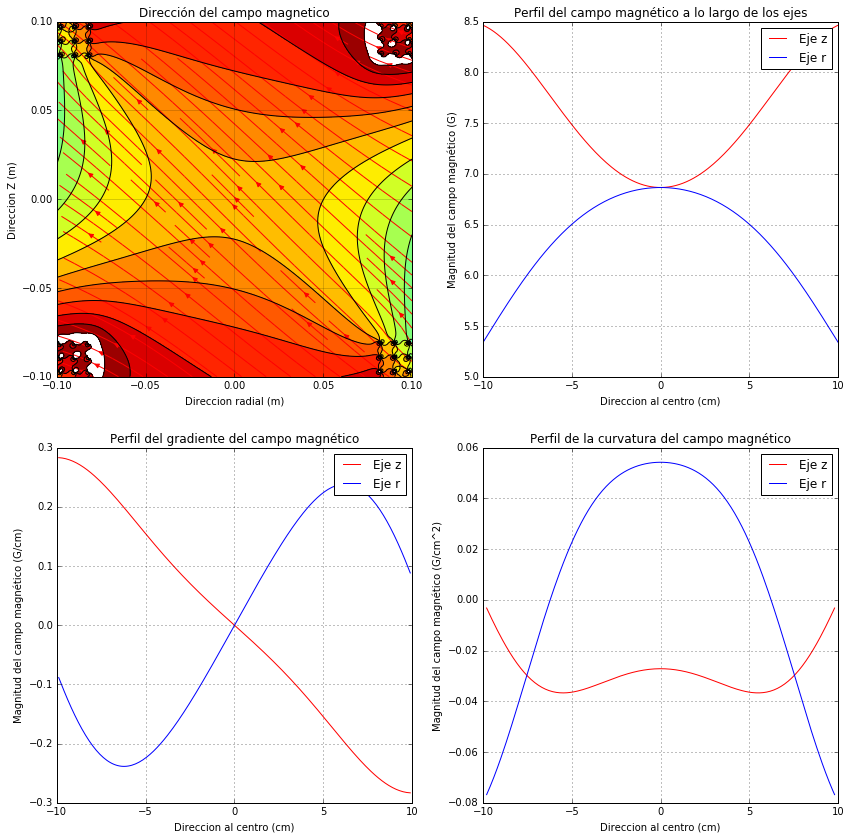

In [56]:
i, h, l, r, Nx, Ny = 1., 162e-3, 164e-3, 4e-3, 10, 10
Angles = [[0,0],[pi/2,0],[pi/2,-pi/2]]
bobina_cuadrada(i, h, l, r, Nx, Ny, Angles)